<center><img src="https://s-media-cache-ak0.pinimg.com/originals/ea/4a/2e/ea4a2e6cb681fba1f5aa29ef16744937.gif" style="margin: 45px; height: 240px">


# Agency Scraping and Network Analysis

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping agent rosters from agency sites

In [4]:
top_domains_dict = {
    # these are the agencies and their URLs to pass into our function:
    'pr':'https://primarytalent.com/roster/u/',
}

In [12]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import requests
import bs4
from bs4 import BeautifulSoup

def scrape(domain):
    
    check_companies = ['']
    all_salaries = []
    all_titles = []
    all_locations = []
    all_summaries = []
    all_companies = []
    all_coratings = []
    all_dates = []

    for page in tqdm(range(0, 10000, 10)):

        these_salaries = []
        these_titles = []
        these_locations = []
        these_summaries = []
        these_companies = []
        these_coratings = []
        these_dates = []

        r_ = requests.get(str(top_domains_dict.get(domain))+
                          'start={}'.format(page))

        # parse the HTML of the page
        soup = BeautifulSoup(r_.text, 'html.parser')

        # extract the 10x companies on this page and append each to these_companies
        for job in soup.find_all('div', attrs={'class':" row result"}):
            span_ = job.find('span', attrs={'class': "company",})
            if span_: these_companies.append(span_.text.strip())
            else: these_companies.append('Unspecified company')

        # do those last ten companies match the last twenty companies scraped?
        if (these_companies == check_companies[-1]) and (these_companies == check_companies[-2]): break

        # if not, let's add them to check_salaries (for checking again when we reach the next page)
        # and to all_salaries, simultaneously adding locations to all_locations, titles to all_titles etc
        else:
            check_companies.append(these_companies)
            all_companies.extend(these_companies)

            for job in soup.find_all('div', attrs={'class':" row result"}):

                a_ = job.find('a',
                              attrs={'class': "turnstileLink",'data-tn-element': 'jobTitle'}
                             )
                if a_: these_titles.append(a_.text.strip())
                else: these_titles.append('Unspecified title')

                span_ = job.find('span', 
                                 attrs={'class': "location"}
                                )
                if span_: these_locations.append(span_.text.strip())
                else: these_locations.append('Unspecified location')

                span_ = job.find('span', 
                                 attrs={'class': "summary"}
                                )
                if span_: these_summaries.append(span_.text.strip())
                else: these_summaries.append('Unspecified summary')

                span_ = job.find('span', 
                                 attrs={'class': "rating"}
                                )
                # use .style instead of .text since we are scraping an attrb (width in px of filled ⭐️)
                if span_: these_coratings.append(span_['style'].replace('width:','').replace('px',''))
                else: these_coratings.append('Unspecified rating')

                td_ = job.find('td', 
                               attrs={'class': "snip"}
                              )
                nowr = td_.find('span', 
                                attrs={'class': "no-wrap"}
                               )
                if nowr: these_salaries.append(nowr.text.strip())
                else: these_salaries.append('Unspecified salary')

                table_ = job.find('table')
                tr_ = table_.find('tr')
                td_ = tr_.find('td')
                div_ = td_.find('div', attrs={'class':"result-link-bar-container"})
                div_ = div_.find('div', attrs={'class':"result-link-bar"})
                date_ = div_.find('span', attrs={'class':"date"})
                if date_: these_dates.append(date_.text.strip())
                else: these_dates.append('Unspecified date')

            all_titles.extend(these_titles)
            all_locations.extend(these_locations)
            all_summaries.extend(these_summaries)
            all_coratings.extend(these_coratings)
            all_salaries.extend(these_salaries)
            all_dates.extend(these_dates)

    df = pd.DataFrame({
        'country':domain if len(domain)==2 else "United States",
        'salary':all_salaries,
        'title':all_titles,
        'location':all_locations,
        'city':[loc.split(',')[0] for loc in all_locations],
        'summary':all_summaries,
        'company':all_companies,
        'company_rating':all_coratings,
        'date':all_dates,
    })
    
    return df

In [13]:
## TO PERFORM THE FULL SCRAPE (NB 10-15 minutes required!) for all domains, from scratch, run these 4 lines:
top_domains_df = pd.concat([scrape(domain) for domain in top_domains_dict.keys()])
top_domains_df.to_csv('top_domains_df.csv', index=False)
print(top_domains_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 9 columns):
country           0 non-null object
salary            0 non-null float64
title             0 non-null float64
location          0 non-null float64
city              0 non-null float64
summary           0 non-null float64
company           0 non-null float64
company_rating    0 non-null float64
date              0 non-null float64
dtypes: float64(8), object(1)
memory usage: 76.0+ bytes
None


In [14]:
top_domains_df

# ## ALTERNATIVELY, just load in the data from stored csv; all cells from here onward will work in both cases:
# top_domains_df = pd.read_csv('top_domains_df.csv', index_col=None)

,country,salary,title,location,city,summary,company,company_rating,date


In [37]:
# a handful of jobs in countries using atypical decimal notation were advertised with salaries < EUR 1,000;
# let's undo the 1k conversion on this subset:
top_domains_df['salary_num']=top_domains_df['salary_num'].apply(lambda x: x/1000 if x>5000000 else x)
top_domains_df[top_domains_df['salary_num']>1000000] # checking the mask reveals no remaining issues of this type

,city,company,company_rating,country,date,location,salary,summary,title,salary_num


In [38]:
# 1 job (at Big Wednesday Digital) was advertised with Australia as country AND city;
# let's remove this, seeing as a brief search on Google did not yield any info about this company:
top_domains_df = top_domains_df[top_domains_df['city']!='Australia']
top_domains_df[top_domains_df['city']=='Australia'] # checking the mask reveals no remaining issues of this type

,city,company,company_rating,country,date,location,salary,summary,title,salary_num


In [99]:
# 1 job was advertised with New York State as location, 1 with Washington State, etc
# (all other USA data followed the format of having state abbrv straight after the comma);
# let's convert this subset to the standard format:
top_domains_df['location']=top_domains_df['location'].apply(lambda x: 'Unknown city, NY' if x=='New York State' else x)
top_domains_df['location']=top_domains_df['location'].apply(lambda x: 'Unknown city, WA' if x=='Washington State' else x)
top_domains_df['location']=top_domains_df['location'].apply(lambda x: 'Unknown city, VA' if x=='Virginia' else x)

In [100]:
top_domains_df.to_csv('top_domains_df.csv', index=False) # storing these recent amendments

salary_num    0.431743
dtype: float64


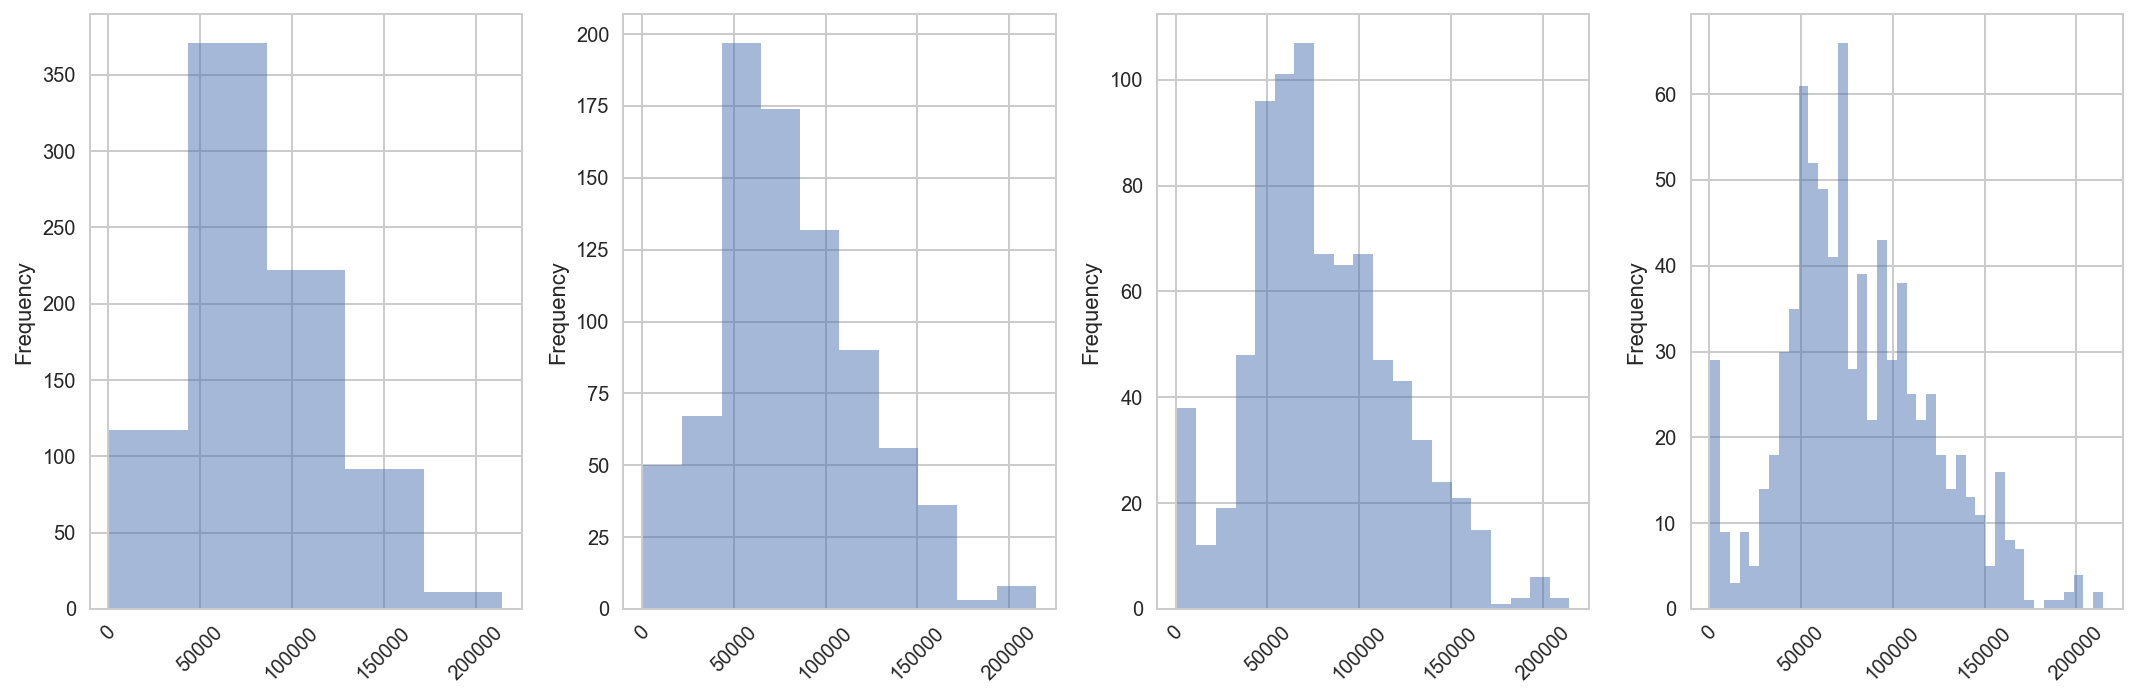

In [101]:
print('SKEW:',top_domains_df.skew())

fig = plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
ax1 = top_domains_df['salary_num'].plot.hist(bins=5, alpha=.5)
plt.subplot(1,4,2)
ax2 = top_domains_df['salary_num'].plot.hist(bins=10, alpha=.5)
plt.subplot(1,4,3)
ax3 = top_domains_df['salary_num'].plot.hist(bins=20, alpha=.5)
plt.subplot(1,4,4)
ax4 = top_domains_df['salary_num'].plot.hist(bins=40, alpha=.5)

for ax in [ax1,ax2,ax3,ax4]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
fig.tight_layout();
plt.savefig('histograms.png')

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

#### Load in the the data of scraped salaries

In [55]:
df = pd.read_csv('top_domains_df.csv', index_col=None)

In [56]:
df.head()

,city,company,company_rating,country,date,location,salary,summary,title,salary_num
0,Macquarie University NSW,Macquarie University,52.2,au,9 days ago,Macquarie University NSW,"$100,706 - $112,058 a year",We are seeking a Data Science Research Enginee...,Data Science Research Engineer,82977.96
1,Melbourne VIC,Deloitte,51.0,au,4 days ago,Melbourne VIC,"$80,000 a year","Be the bridge between Business SME, data scien...",Data Analyst,62400.00
2,Melbourne VIC,Deloitte,51.0,au,12 days ago,Melbourne VIC,"$120,000 a year","Be the bridge between data scientists, enginee...",Deloitte Data Hub Architect,93600.00
3,Brisbane QLD,Queensland University of Technology,52.8,au,15 days ago,Brisbane QLD,"$92,338 - $101,007 a year",Social media data and other digital data at. D...,"Developer / Data Scientist, Digital Observatory",75404.55
4,Edinburgh SA,Australian Government Department of Defence,51.6,au,4 days ago,Edinburgh SA,"$138,293 - $155,630 a year",The Group Leader Data and Information Fusion r...,EL 2 (S&T 7) - Group Leader - Data and Informa...,114629.97


In [57]:
for col in df[['company', 'location', 'title']]:
    if col == 'company':
        txt = ','.join([s_.replace(' ','') for s_ in df[col]])
    else:
        txt = ','.join([s_ for s_ in df[col]])
    f_ = open('textcloud_of_'+col+'.txt', 'w')
    f_.write(txt)
    f_.close()
    
# A 4th file for City+State concatenated data
txt = ','.join([s_.replace(' ','').replace(',','') for s_ in df['location']])
f_ = open('textcloud_of_location_concats.txt', 'w')
f_.write(txt)
f_.close()

In [45]:
%%bash 
wordcloud_cli.py --text textcloud_of_company.txt --imagefile wordcloud_of_company.png --no_collocations \
--mask geekout.jpeg --colormask geekout.jpeg --background white
wordcloud_cli.py --text textcloud_of_summary.txt --imagefile wordcloud_of_summary.png --no_collocations \
--mask geekout.jpeg --colormask geekout.jpeg --background white
wordcloud_cli.py --text textcloud_of_location.txt --imagefile wordcloud_of_location.png --no_collocations \
--mask geekout.jpeg --colormask geekout.jpeg --background white
wordcloud_cli.py --text textcloud_of_location_concats.txt --imagefile wordcloud_of_location_concats.png --no_collocations \
--mask geekout.jpeg --colormask geekout.jpeg --background white
wordcloud_cli.py --text textcloud_of_title.txt --imagefile wordcloud_of_title.png --no_collocations \
--mask geekout.jpeg --colormask geekout.jpeg --background white

These wordclouds are not quantitative but provide a simple way to visualise the prevalence of certain words in each category (location, title, job description etc) and align our expectations for later analysis).

<table><tr>
    <td><img src='wordcloud_of_company.png' width=240>COMPANIES</td>
    <td><img src='wordcloud_of_summary.png' width=240>SUMMARIES</td>
    <td><img src='wordcloud_of_location.png' width=240>LOCATIONS (Split)</td>
    <td><img src='wordcloud_of_location_concats.png' width=240>LOCATIONS (Concatenated)</td>
    <td><img src='wordcloud_of_title.png' width=240>JOB TITLES</td>
</tr></table>

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [58]:
df.groupby(pd.cut(df["salary_num"], 100)).count().head(2)

,city,company,company_rating,country,date,location,salary,summary,title,salary_num
salary_num,,,,,,,,,,
"(326.04, 2679.6]",19,19,19,19,19,19,19,19,19,19
"(2679.6, 4819.2]",8,8,8,8,8,8,8,8,8,8


In [59]:
df.groupby(pd.cut(df["salary_num"], 100)).count().tail(2)

,city,company,company_rating,country,date,location,salary,summary,title,salary_num
salary_num,,,,,,,,,,
"(210220.8, 212360.4]",0,0,0,0,0,0,0,0,0,0
"(212360.4, 214500.0]",1,1,1,1,1,1,1,1,1,1


In [60]:
df['salary_band'] = df.groupby(pd.cut(df["salary_num"], 20000))['salary_num'].transform(lambda x: round(x.count()))
df.head()

,city,company,company_rating,country,date,location,salary,summary,title,salary_num,salary_band
0,Macquarie University NSW,Macquarie University,52.2,au,9 days ago,Macquarie University NSW,"$100,706 - $112,058 a year",We are seeking a Data Science Research Enginee...,Data Science Research Engineer,82977.96,2.0
1,Melbourne VIC,Deloitte,51.0,au,4 days ago,Melbourne VIC,"$80,000 a year","Be the bridge between Business SME, data scien...",Data Analyst,62400.00,1.0
2,Melbourne VIC,Deloitte,51.0,au,12 days ago,Melbourne VIC,"$120,000 a year","Be the bridge between data scientists, enginee...",Deloitte Data Hub Architect,93600.00,6.0
3,Brisbane QLD,Queensland University of Technology,52.8,au,15 days ago,Brisbane QLD,"$92,338 - $101,007 a year",Social media data and other digital data at. D...,"Developer / Data Scientist, Digital Observatory",75404.55,1.0
4,Edinburgh SA,Australian Government Department of Defence,51.6,au,4 days ago,Edinburgh SA,"$138,293 - $155,630 a year",The Group Leader Data and Information Fusion r...,EL 2 (S&T 7) - Group Leader - Data and Informa...,114629.97,1.0


count       813.000000
mean      80751.489533
std       40043.187198
min         540.000000
25%       53250.000000
50%       74400.000000
75%      106500.000000
max      214500.000000
Name: salary_num, dtype: float64


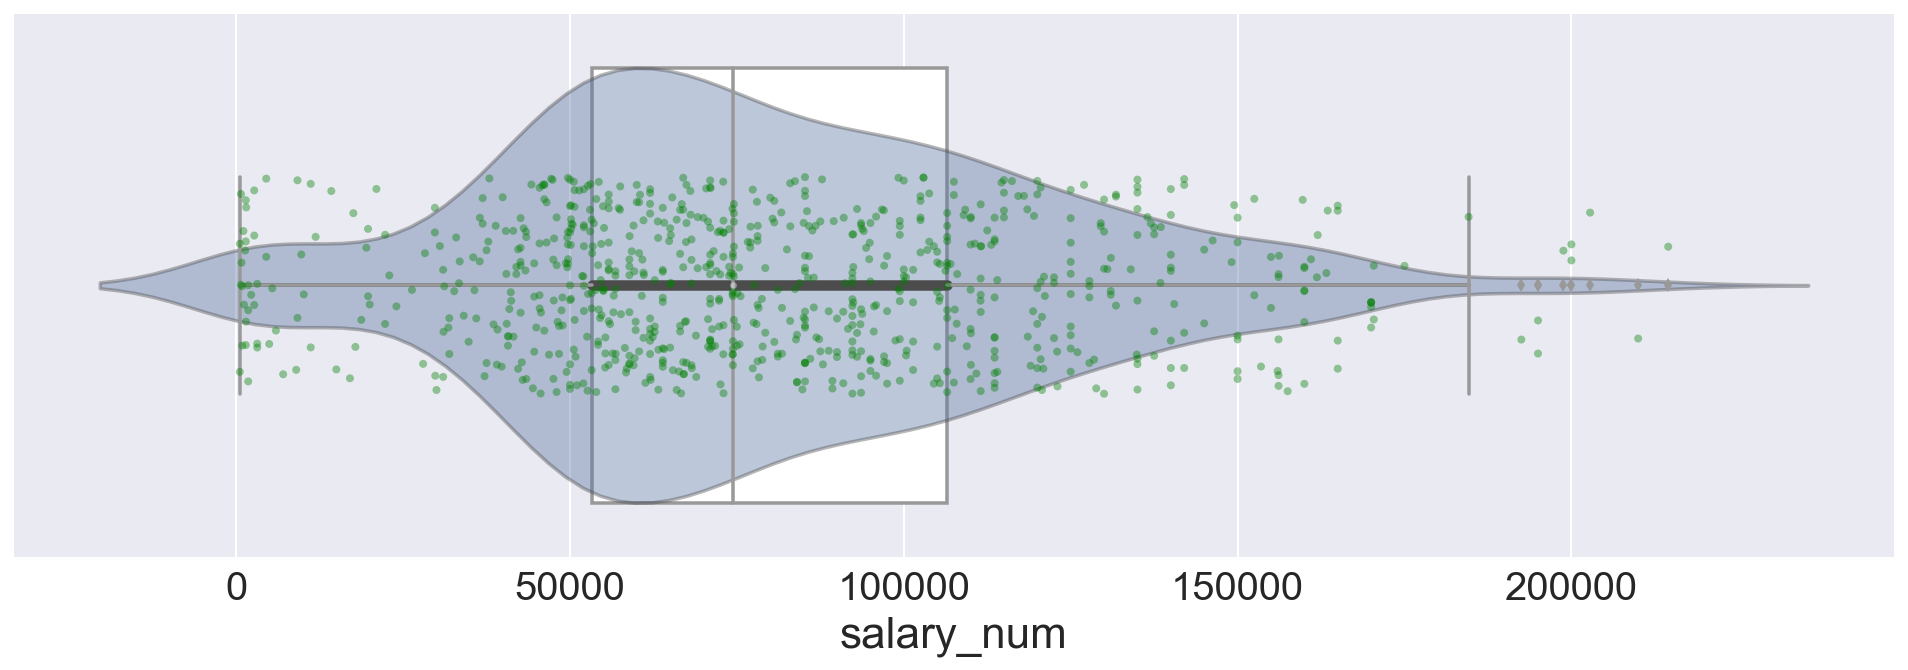

In [374]:
print(df['salary_num'].describe())
data = df['salary_num']

import seaborn as sns
sns.set(font_scale = 2)
plt.figure(figsize=(15,5))

# STRIP PLOT to show the binary color split: 
sns.stripplot(data,
                  jitter=0.2,
                  size =4,
                  color ='g',
                  # hue=hi_lo,
                 )

# VIOLIN PLOT to show the distribution:
ax = sns.violinplot(data,
              )

# BOX PLOT to show the quartiles:
sns.boxplot(data,
            color='w',
           )

# AESTHETICS
plt.setp(ax.collections, alpha=.4);
plt.savefig('plot_combo.png')

In [219]:
import pandas as pd
salaries_by_state_ave = pd.read_csv('top_domains_df.csv')

full_names = {'uk':'United Kingdom',
              'NY':'New York',
              'fr':'France',
              'VA':'Virginia',
              'CA':'California',
              'nl':'Netherlands',
              'in':'India',
              'au':'Australia',
              'IL':'Illinois',
              'DC':'District of Columbia',
              'MA':'Massechusetts',
              'ca':'Canada',
              'TX':'Texas',
              'sg':'Singapore',
              'WA':'Washington',
              'MD':'Maryland',
              'es':'Spain'}

# split USA into its states and set these equivalent to the other countries scraped
def countrify(x):
    if x['country'] == 'United States':
        return full_names[x['location'].split(',')[1][1:3]]
    else:
        return full_names[x['country']]
    
salaries_by_state_ave['state'] = salaries_by_state_ave.apply(
    lambda x: countrify(x), axis=1)

salaries_by_state_ave['state'].value_counts()

# STATE MEAN using split-apply-combine
salaries_by_state_ave['state_mean'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(x.mean()))

# STATE MEDIAN using split-apply-combine
salaries_by_state_ave['state_medi'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(x.median()))

# STATE 25th using split-apply-combine
salaries_by_state_ave['state_25th'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(np.percentile(x, 25)))

# STATE 75th using split-apply-combine
salaries_by_state_ave['state_75th'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(np.percentile(x, 75)))

# STATE MIN using split-apply-combine
salaries_by_state_ave['state_min_'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(min(x)))

# STATE MAX using split-apply-combine
salaries_by_state_ave['state_max_'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(max(x)))

# STATE STANDARD DEVATION using split-apply-combine
salaries_by_state_ave['state_stdv'] = salaries_by_state_ave.groupby('state',
                                                                    as_index=False,
                                                                   )['salary_num'].transform(lambda x: round(x.std()))

# HI/LO labels for each measure, so we can page between measures later during Tableau plotting
for agg in ['mean', 'medi', '25th', '75th', 'stdv']:
    salaries_by_state_ave['state_'+agg+'_rel'] = np.where(
        salaries_by_state_ave['salary_num'] > salaries_by_state_ave['state_'+agg],'hi','lo')

salaries_by_state_ave.to_csv('salaries_by_state_ave.csv', index=False)
salaries_by_state_ave[salaries_by_state_ave['company_rating']!='Unspecified rating'].to_csv(
    'salaries_by_state_ave_with_ratings.csv', index=False)

<img src='plots_tableau/Boxes.png' width=640>

In [220]:
print(" across all geographical regions (country or US state) investigated,\n",
      "in multiples of the region's standard deviation in salary,\n",
      '\naverage displacement of min from the mean =',
      round(((salaries_by_state_ave['state_min_']-salaries_by_state_ave['state_mean'])/
             salaries_by_state_ave['state_stdv']).mean(),3),
      '\naverage displacement of 25th percentile from the mean =',
      round(((salaries_by_state_ave['state_25th']-salaries_by_state_ave['state_mean'])/
             salaries_by_state_ave['state_stdv']).mean(),3),
      '\naverage displacement of 75th percentile from the mean =',
      round(((salaries_by_state_ave['state_75th']-salaries_by_state_ave['state_mean'])/
             salaries_by_state_ave['state_stdv']).mean(),3),
      '\naverage displacement of max from the mean =',
      round(((salaries_by_state_ave['state_max_']-salaries_by_state_ave['state_mean'])/
             salaries_by_state_ave['state_stdv']).mean(),3),
      )

 across all geographical regions (country or US state) investigated,
 in multiples of the region's standard deviation in salary,
 
average displacement of min from the mean = -1.898 
average displacement of 25th percentile from the mean = -0.692 
average displacement of 75th percentile from the mean = 0.535 
average displacement of max from the mean = 2.835


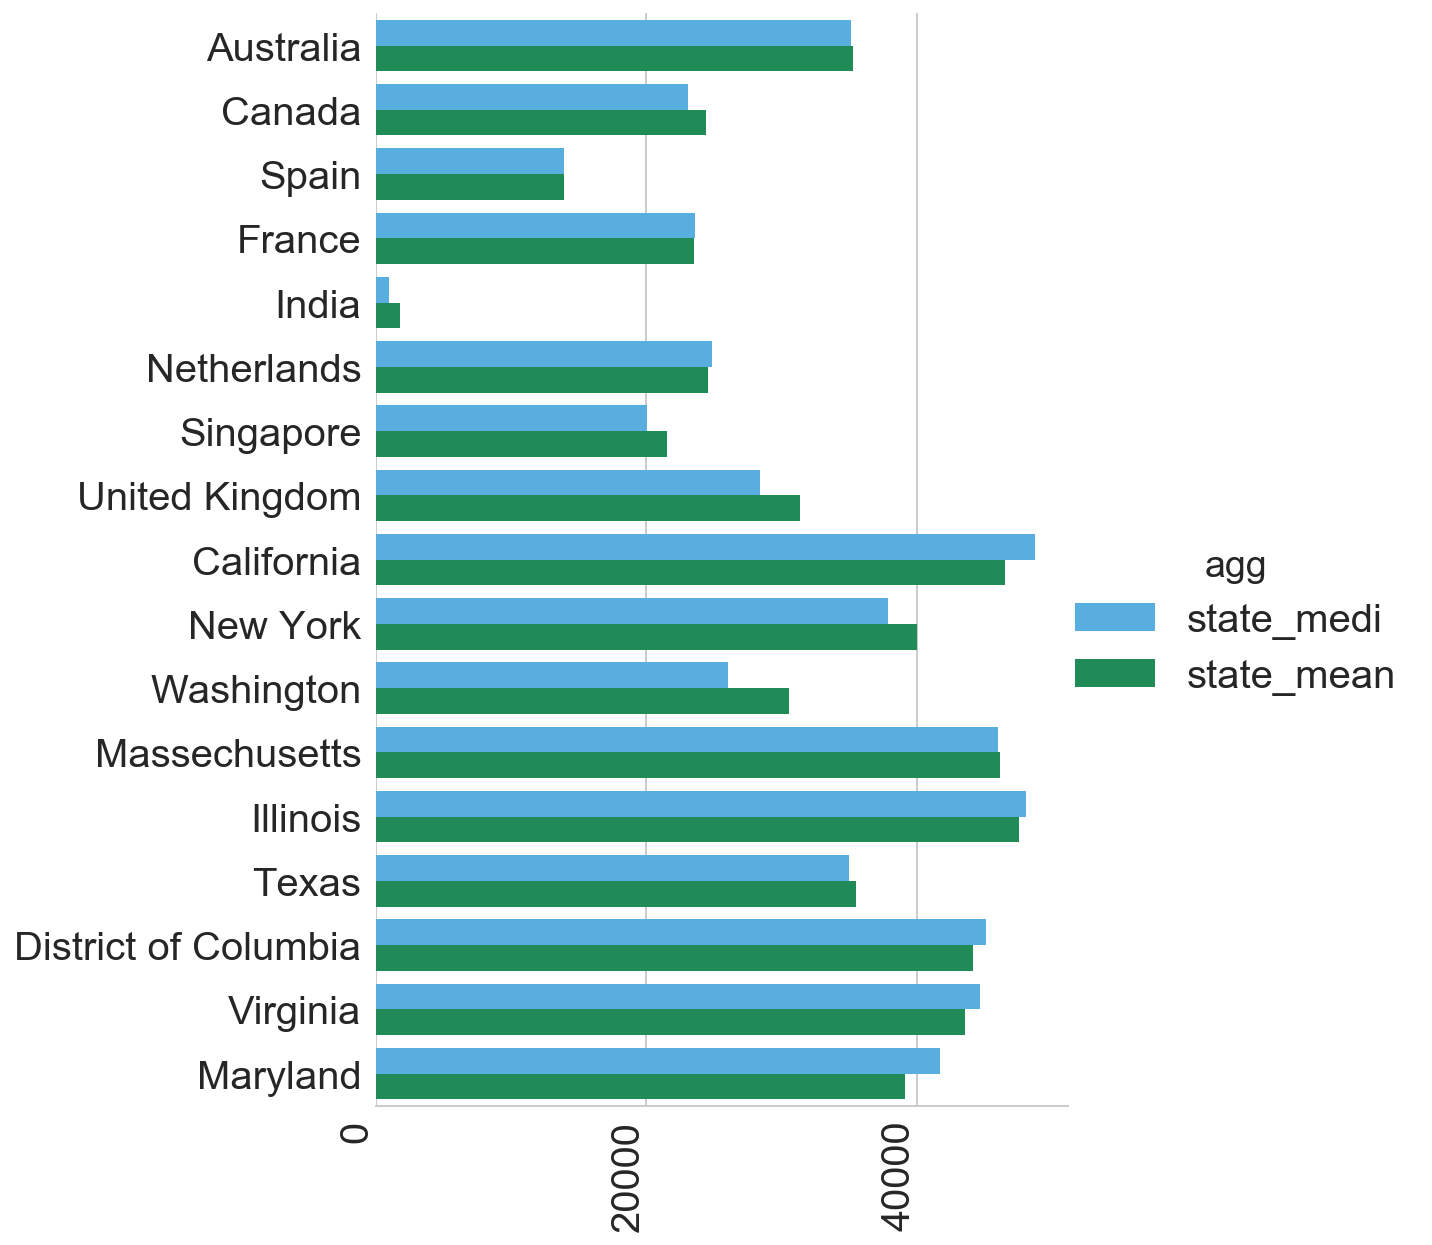

In [221]:
melted = pd.melt(salaries_by_state_ave[[
    'state',
#     'state_25th',
    'state_medi',
    'state_mean',
#     'state_75th',
]],
    id_vars='state',
    var_name="agg",
    value_name="amt").drop_duplicates()

import seaborn as sns
sns.set(style="whitegrid", font_scale=2)
goog = ["#42B5F4", "#0F9D58", "#F4B400", "#DB4337"]

g = sns.factorplot(y="state", x="amt", hue="agg", data=melted,
                   size=9, kind="bar", palette=goog
                   ).set_xticklabels(rotation=90, horizontalalignment='right',
                                     fontsize=20).set_yticklabels(fontsize=20)

g.despine(left=True)
g.set_xlabels("")
g.set_ylabels("");

# except in the case of Washington, the mean salary for each of the American states
# is higher than that of any of the mean salaries of the non-USA countries...!

#### Thought experiment: What is the baseline accuracy for this model?

In [222]:
salaries_by_state_ave['state_medi'].mean()

78254.85608856089

### Create a classification model to predict High/Low salary. 

#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

###### K-means

In [223]:
salaries_by_state_ave['state'].value_counts()

United Kingdom          213
France                   72
Texas                    71
Virginia                 66
Australia                65
Netherlands              58
New York                 42
India                    38
Washington               33
Canada                   31
Massechusetts            31
Illinois                 27
District of Columbia     24
California               16
Singapore                12
Maryland                 12
Spain                     2
Name: state, dtype: int64

In [224]:
# unique states ordered by most prevalent i.e. United Kingdom first:
unique_states = list(salaries_by_state_ave['state'].value_counts().keys())

state_encoder = {k:v for (k,v) in zip(unique_states,range(len(unique_states)))}
salaries_by_state_ave['state_encoded'] = salaries_by_state_ave['state'].apply(lambda x: state_encoder.get(x))
salaries_by_state_ave[['state','state_encoded']].sample(5)

,state,state_encoded
460,United Kingdom,0
133,France,1
215,Netherlands,5
343,United Kingdom,0
567,Washington,8


By encoding the states (if not already clear, "state" here refers to countries except in the case of USA where it refers to states) in order of their prevalence in the "numerical salaries" DataFrame labelled `salaries_by_state_ave`, we're effectively going to be plotting "number of salaries advertised" as a predictor for "state median". This could be more simply done by plotting the actual `.value_counts()` per state, but I found there was no relationship and wanted to showcase the encoding method (above) in order to perform a K-means clustering routine (below).

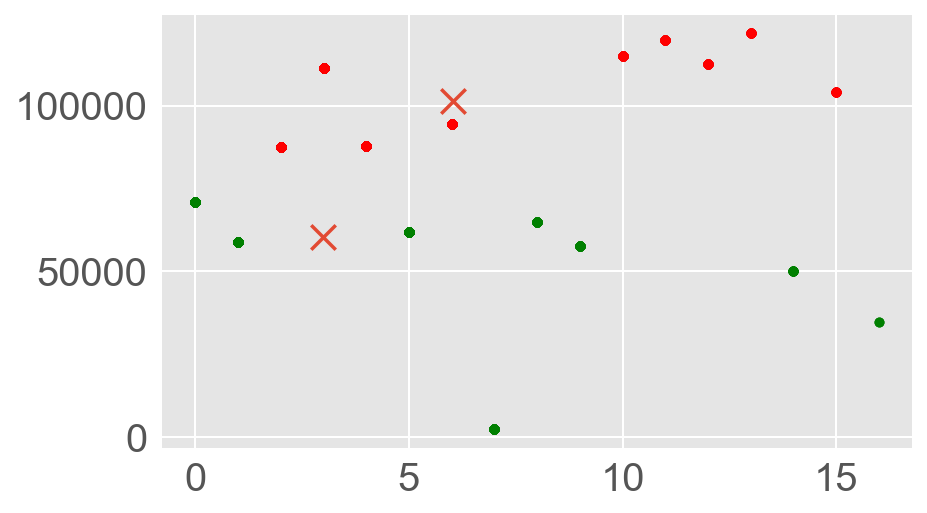

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

# # this would've been how to one-hot encode the 'state' column
# X = pd.get_dummies(salaries_by_state_ave[['state']], drop_first=True)

# # ...instead, I'm encoding each state with a value of 0,1,2,3 ordered by number of salaries advertised
X = salaries_by_state_ave[['state_encoded',   
                           'state_medi']] # the target variable for K-means clustering
# X.head()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_ # in this line the algorithm determines labels for k clusters

colors = ["g.","r."]

for i in range(len(X)):
    plt.plot(X.iloc[i][0], X.iloc[i][1], colors[labels[i]], markersize = 10)

plt.scatter(centroids[:, 0],
            centroids[:, 1],
            marker = "x", s=150,
            linewidths = 5, zorder = 10);

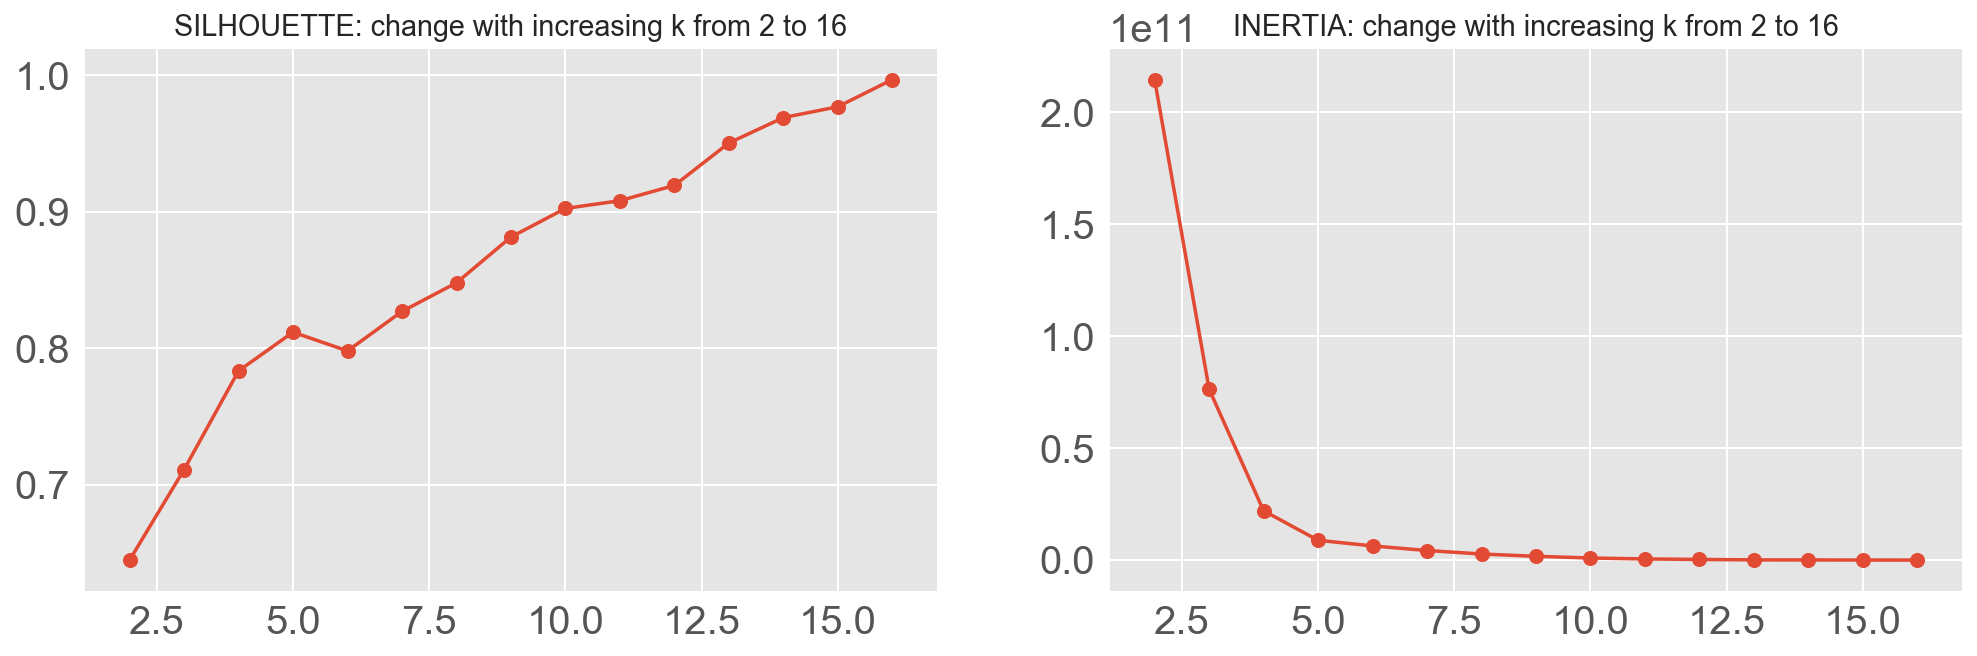

In [226]:
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics

ss = StandardScaler()
Xs = ss.fit_transform(X) # ended up not using this, but have left in for ref
                         # the slopes were very different with standardising

# we'll investigate k up to a maximum of the number of unique states
range_ = range(2,len(unique_states))

plt.figure(figsize=(15,5))

# first plot the change in SILHOUETTE with increasing k
plt.subplot(1,2,1)
plt.title('SILHOUETTE: change with increasing k from 2 to '+str(max(range_)))
sils = []
for k in range_:
    km = cluster.KMeans(n_clusters=k)
    km.fit(X)
    sils.append(metrics.silhouette_score(X, km.labels_, metric='euclidean'))
plt.plot(range_, sils)
plt.scatter(range_, sils)

# now plot INERTIA with increasing k (aka SCREE PLOT)
plt.subplot(1,2,2)
plt.title('INERTIA: change with increasing k from 2 to '+str(max(range_)))
inertias = []
for k in range_:
    km = cluster.KMeans(n_clusters=k)
    km.fit(X)
    inertias.append(km.inertia_)
plt.plot(range_, inertias)
plt.scatter(range_, inertias);

###### Logistic Regression with Statsmodels

In [248]:
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# import statsmodels.formula.api as smf

# loc_model = smf.logit(
#     'state_encoded'+
#     '~ C(state, Treatment(reference="United Kingdom"))', 
#                      data=salaries_by_state_ave).fit()
# loc_model.summary()
# # unfortunately it was not possible in the time, to complete this part of my answer

###### Logistic Regression with SKLearn

In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dummified_state = pd.get_dummies(salaries_by_state_ave, columns=['state'], drop_first=True)
dummified_state.head()
y = salaries_by_state_ave.salary_num
X = pd.DataFrame(X,columns=['state'],index=salaries_by_state_ave.index)

In [242]:
print(model.params)
print('Logreg intercept:', model.params[0])
# print('Logreg coef(s):', model.params[1])
# print('Logreg predicted classes:', 1*(model.predict(X.iloc[:5,:])>0.5).values)

# Check that all predictions are the same for sklearn and statsmodels
# (logreg.predict(X)-1*(model.predict(X)>0.5)).sum()

Intercept   -2.511862
dtype: float64
Logreg intercept: -2.5118624597765287


#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC curve for at least one of your models.

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC curves for the different models you studied (at least the tuned model of each category) and compare.

###### Analysing some keywords

In [230]:
title_kws = ['senior', 'sr', # 'snr',
             'junior', # 'jr', 'jnr',
             'manager', # 'mgmt', 'mgr',
             'machine learning', 'tableau', 'deep learning', 'java',
             
             # (the various commented items were not found in any titles)
             ]

for title_kw in title_kws:

    salaries_by_state_ave[title_kw+'_in_title'] = salaries_by_state_ave['title'].apply(
        lambda x:
        1 if title_kw in x.lower()
        else 0)

#     print(salaries_by_state_ave[title_kw].value_counts())
salaries_by_state_ave.sort_values(
    'senior_in_title', ascending=False)[[
        title_kw+'_in_title'
        for title_kw in title_kws
    ]].head(5)

,senior_in_title,sr_in_title,junior_in_title,manager_in_title,machine learning_in_title,tableau_in_title,deep learning_in_title,java_in_title
406,1,0,0,0,0,0,0,0
456,1,0,0,0,0,0,0,0
355,1,0,0,0,0,0,0,0
356,1,0,0,0,0,0,0,0
657,1,0,0,0,0,0,0,0


In [231]:
summary_kws = ['senior', 'sr', # 'snr',
               'junior', # 'jr', 'jnr',
               'manager', # 'mgmt', 'mgr',
               'machine learning', 'tableau', 'deep learning', 'java',
               
               # these 3 were found in summary but not title:
               'tensorflow', 'big data', 'sql', 
               
               # (the various commented items were not found in any summaries)
               ]

for summary_kw in summary_kws:

    salaries_by_state_ave[summary_kw+'_in_summary'] = salaries_by_state_ave['summary'].apply(
        lambda x:
        1 if summary_kw in x.lower()
        else 0)

#     print(salaries_by_state_ave[title_kw].value_counts())
salaries_by_state_ave.sort_values(
    'senior_in_summary', ascending=False)[[
        summary_kw+'_in_summary'
        for summary_kw in summary_kws
    ]].head(5)

,senior_in_summary,sr_in_summary,junior_in_summary,manager_in_summary,machine learning_in_summary,tableau_in_summary,deep learning_in_summary,java_in_summary,tensorflow_in_summary,big data_in_summary,sql_in_summary
406,1,0,0,0,0,0,0,0,0,0,0
754,1,0,0,0,0,0,0,0,0,1,0
240,1,0,0,0,0,0,0,0,0,0,0
446,1,0,0,0,0,0,0,0,0,0,0
581,1,0,0,0,1,0,1,0,0,0,0


In [232]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.formula.api as smf

loc_model = smf.logit(
    'senior_in_title'+
#     'state_mean_rel'+
#     'state'+
    '~ C(state, Treatment(reference="Australia"))', 
                     data=salaries_by_state_ave).fit()
loc_model.summary()


         Current function value: 0.251669
         Iterations: 35


/Users/oliversteadman/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        senior_in_title   No. Observations:                  813
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                           16
Date:                Tue, 24 Apr 2018   Pseudo R-squ.:                 0.05552
Time:                        08:43:07   Log-Likelihood:                -204.61
converged:                      False   LL-Null:                       -216.63
                                        LLR p-value:                   0.08835
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -2.1145      0.400     -5.285      0.000      -2.899      -1.330
C(state, Treatment(reference="Australia"))[T.California]               0.1686      0.855      0.197      0.844      -1.508       1.845
C(state, Treatment(reference="Australia"))[T.Canada]                  -1.2867      1.092     -1.178      0.239      -3.428       0.854
C(state, Treatment(reference="Australia"))[T.District of Columbia]   -22.5955   4.74e+04     -0.000      1.000   -9.29e+04    9.28e+04
C(state, Treatment(reference="Australia"))[T.France]                  -0.7187      0.652     -1.103      0.270      -1.996       0.559
C(state, Treatment(reference="Australia"))[T.Illinois]                 0.6329      0.637      0.994      0.320      -0.615       1.881
C(state, Treatment(reference="Australia"))[T.India]                  -12.7118    268.905     -0.047      0.962    -539.757     514.333
C(state, Treatment(reference="Australia"))[T.Maryland]                -0.2834      1.118     -0.253      0.800      -2.476       1.909
C(state, Treatment(reference="Australia"))[T.Massechusetts]           -0.1191      0.727     -0.164      0.870      -1.545       1.307
C(state, Treatment(reference="Australia"))[T.Netherlands]             -0.2463      0.616     -0.400      0.689      -1.453       0.960
C(state, Treatment(reference="Australia"))[T.New York]                -0.1368      0.661     -0.207      0.836      -1.432       1.158
C(state, Treatment(reference="Australia"))[T.Singapore]               -0.2834      1.118     -0.253      0.800      -2.476       1.909
C(state, Treatment(reference="Australia"))[T.Spain]                  -12.3705    988.247     -0.013      0.990   -1949.300    1924.559
C(state, Treatment(reference="Australia"))[T.Texas]                   -0.2681      0.585     -0.458      0.647      -1.415       0.878
C(state, Treatment(reference="Australia"))[T.United Kingdom]          -0.3961      0.477     -0.830      0.406      -1.331       0.539
C(state, Treatment(reference="Australia"))[T.Virginia]                -2.0599      1.084     -1.900      0.057      -4.185       0.065
C(state, Treatment(reference="Australia"))[T.Washington]               0.3918      0.629      0.623      0.533      -0.841       1.625
======================================================================================================================================
"""

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = salaries_by_state_ave.state_medi_rel
X = scaler.fit_transform(salaries_by_state_ave[['senior_in_title']])
X = pd.DataFrame(X,columns=['senior_in_title'],index=salaries_by_state_ave.index)
logreg = LogisticRegression()
logreg.fit(X, y)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)
print('Logreg predicted probabilities:\n', logreg.predict_proba(X.iloc[0:5,:]))
print('Logreg predicted classes:', logreg.predict(X.iloc[0:5,:]))

Logreg intercept: [0.03725316]
Logreg coef(s): [[-0.35316277]]
Logreg predicted probabilities:
 [[0.46559505 0.53440495]
 [0.46559505 0.53440495]
 [0.46559505 0.53440495]
 [0.46559505 0.53440495]
 [0.46559505 0.53440495]]
Logreg predicted classes: ['lo' 'lo' 'lo' 'lo' 'lo']


In [234]:
predictions = logreg.predict(X)
print(' sum of predictions =',(predictions==y).sum(),'\n',
      'num of predictions =',len(y),'\n',
      'accuracy (by hand):',(predictions==y).sum()/len(y),'\n',
      'accuracy ( .score):',logreg.score(X,y),
     )

 sum of predictions = 449 
 num of predictions = 813 
 accuracy (by hand): 0.5522755227552275 
 accuracy ( .score): 0.5522755227552275


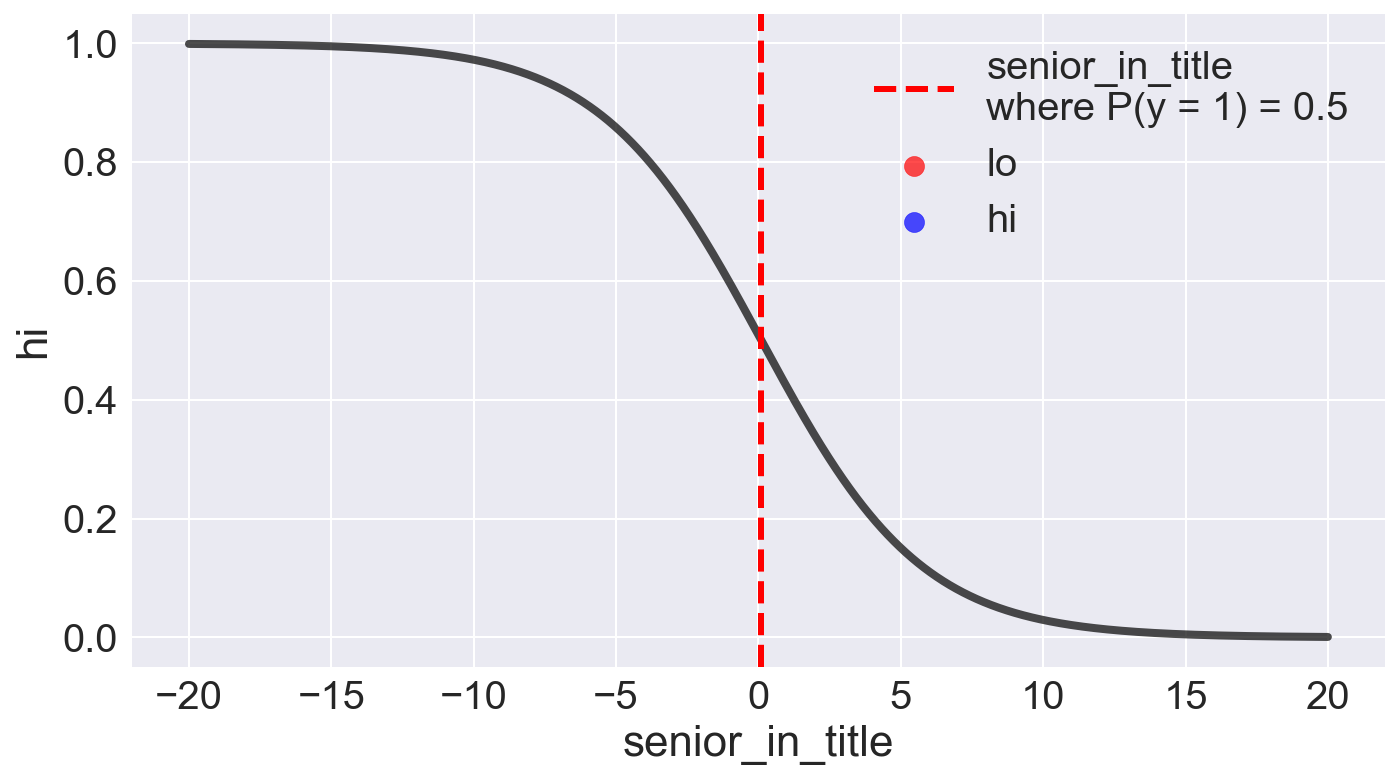

In [246]:
xval_chance = (-1 * logreg.intercept_[0])/logreg.coef_[0][0]

fig, ax = plt.subplots(figsize=(10,6))
sns.set(font_scale = 2)

# plot the logreg regression line for salary_num ~ senior_in_title
x_vals = np.linspace(-20.,20.,3000)
y_pp = logreg.predict_proba(x_vals[:, np.newaxis])[:,1]

ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4)

# do one scatter plot for each class (hi or lo relative to median):
ax.scatter(X.senior_in_title[y == 0],
           y[y == 0],
           c='r', s=100, alpha=0.7,
           label='lo')

ax.scatter(X.senior_in_title[y == 1],
           y[y == 1],
           c='b', s=100, alpha=0.7,
           label='hi')

ax.axvline(xval_chance, lw=3, color='red', ls='dashed',
           label='senior_in_title\nwhere P(y = 1) = 0.5')

ax.set_ylabel('hi')
ax.set_xlabel('senior_in_title')
# ax.set_xlim([-4,4])
# ax.set_title('salary_num ~ senior_in_title, company_rating=1\n', fontsize=20)

plt.legend(loc='upper right');

In [236]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# formula version
import statsmodels.formula.api as sm

X_i = salaries_by_state_ave.copy()
X_i['salary_num'] = y

model = sm.logit('senior_in_title~1',data=X_i).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.266462
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        senior_in_title   No. Observations:                  813
Model:                          Logit   Df Residuals:                      812
Method:                           MLE   Df Model:                            0
Date:                Tue, 24 Apr 2018   Pseudo R-squ.:                   0.000
Time:                        08:43:12   Log-Likelihood:                -216.63
converged:                       True   LL-Null:                       -216.63
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5119      0.133    -18.868      0.000      -2.773      -2.251
==============================================================================
"""

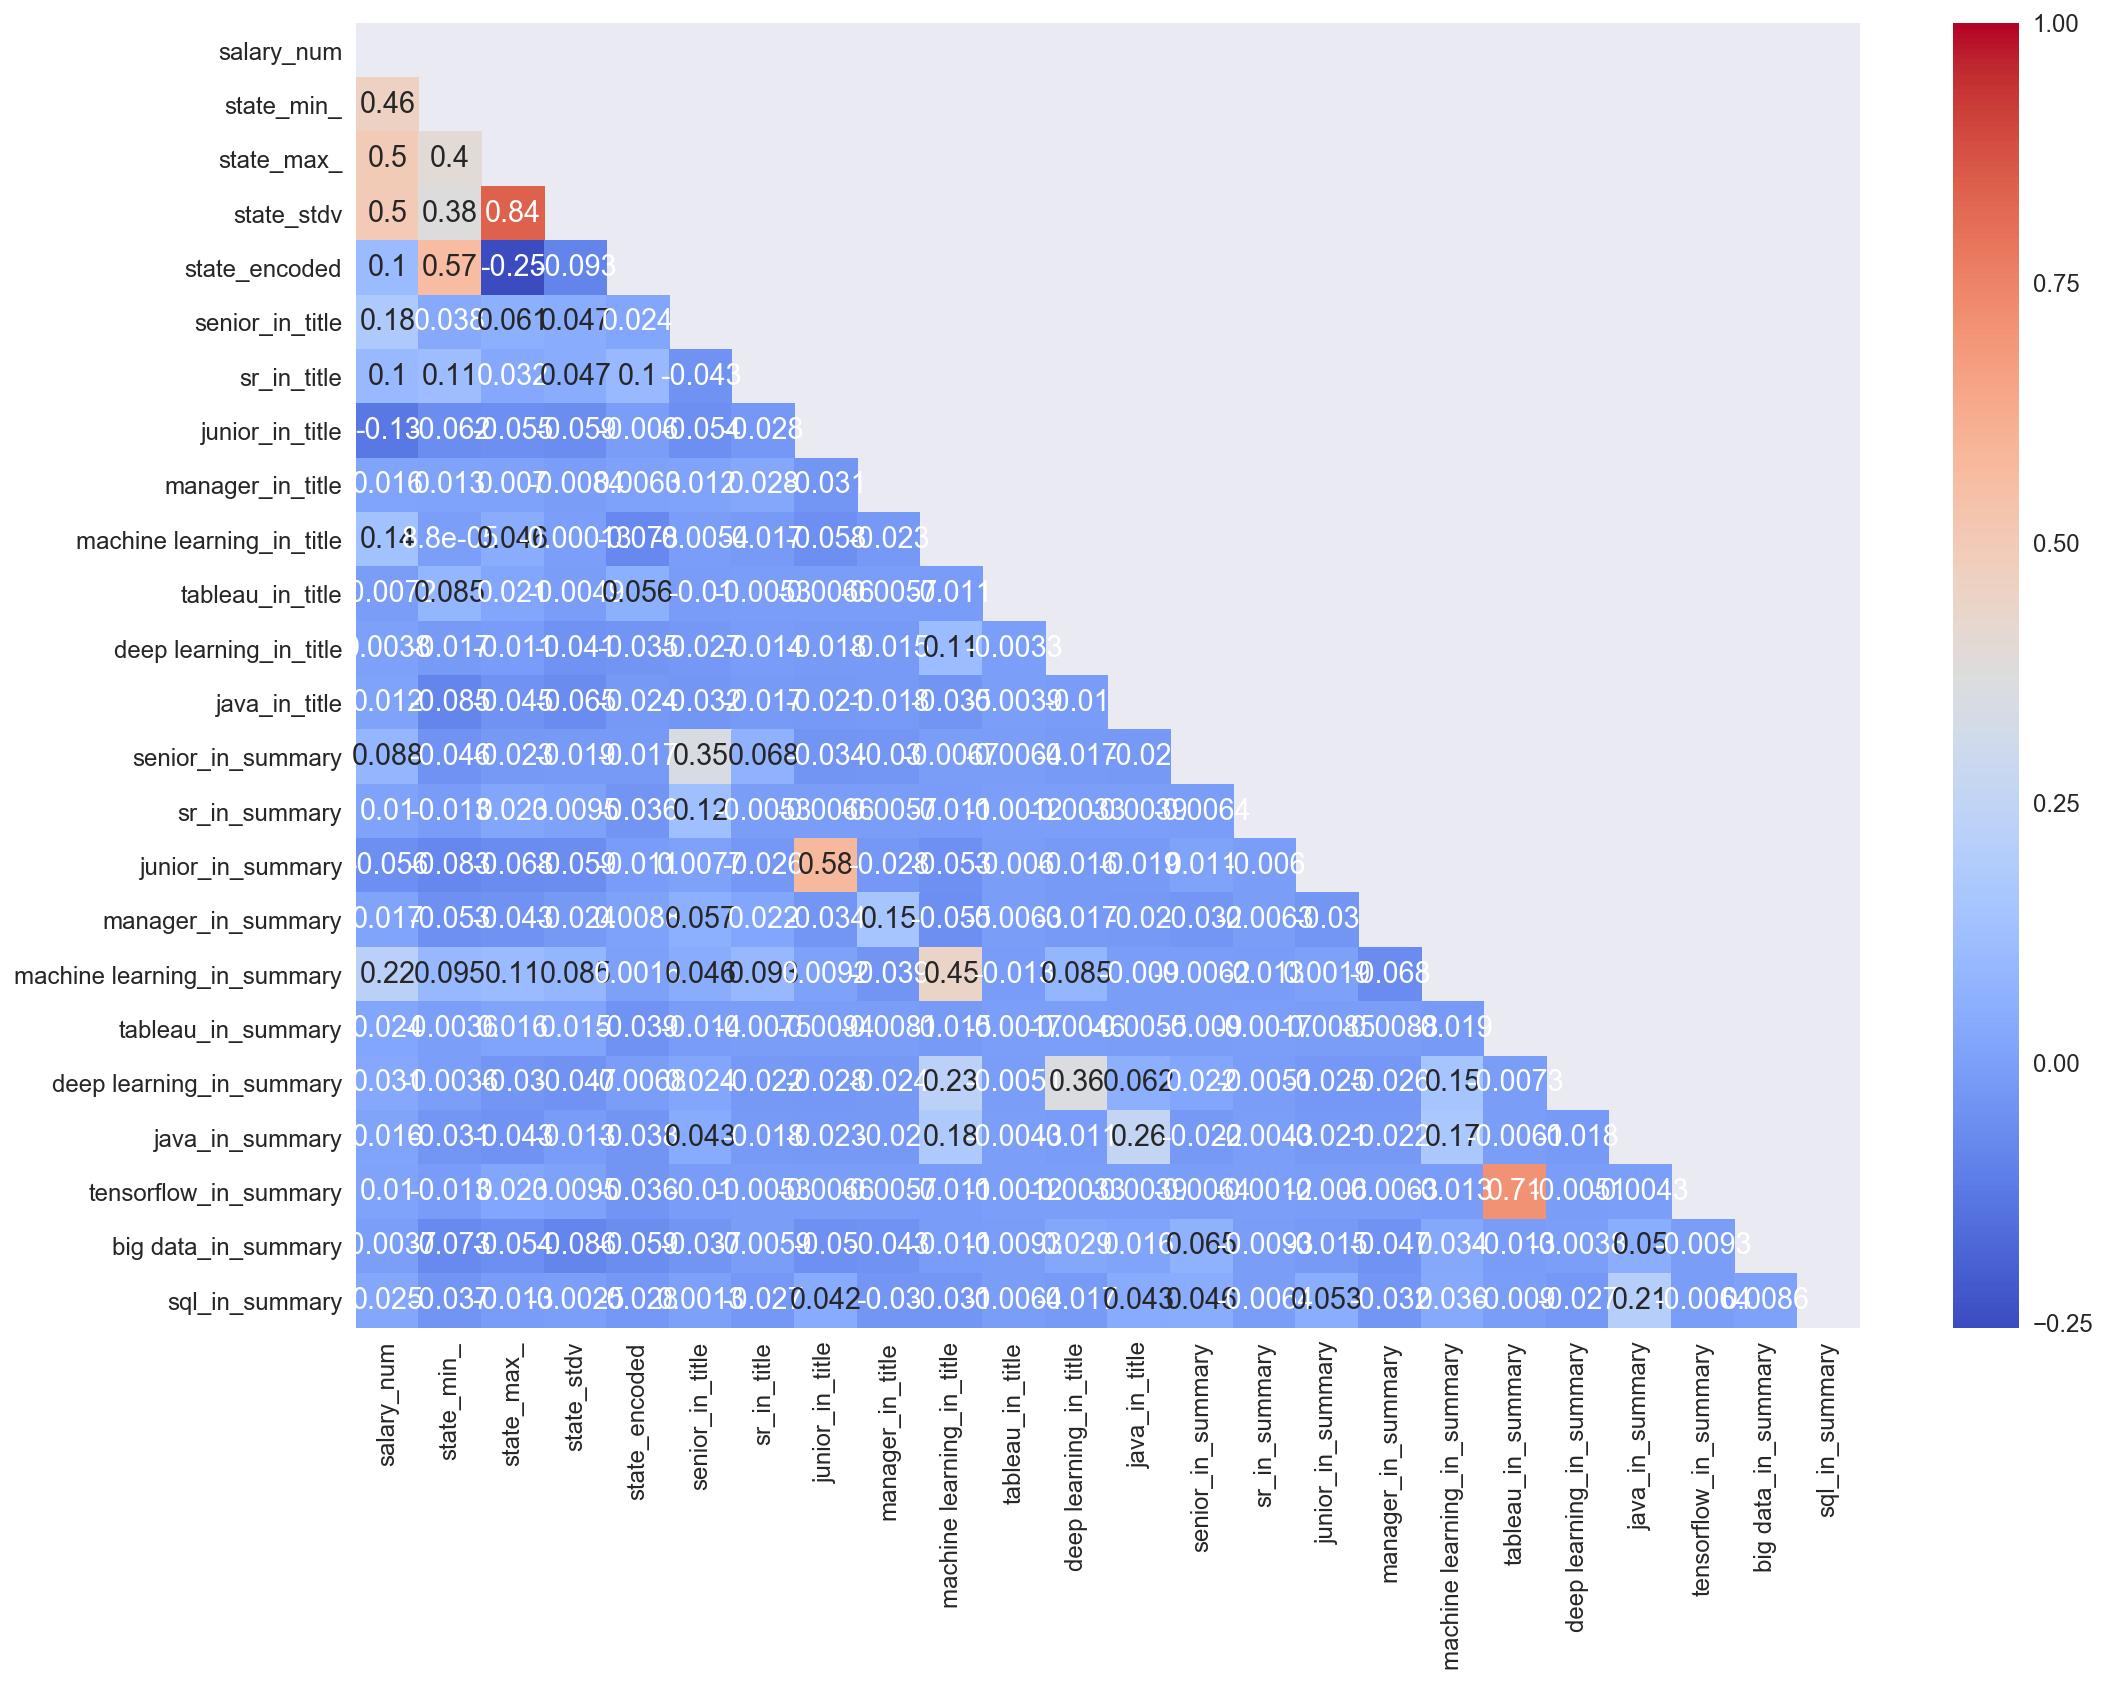

In [237]:
exclude_aggs = [col for col in salaries_by_state_ave.columns
               if not col in [state_agg for state_agg in [
               'state_mean','state_mean_rel',
               'state_medi','state_medi_rel',
               'state_25th','state_25th_rel',
               'state_75th','state_75th_rel',
               ]]]
exclude_aggs

sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(15,12))
mask = np.zeros_like(salaries_by_state_ave[exclude_aggs].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(salaries_by_state_ave[exclude_aggs].corr(), mask=mask,cmap="coolwarm",  ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels())
ax.set_yticklabels(ax.yaxis.get_ticklabels());

One particular correlations is highlighted shown here, unrelated to salary but notable in any case:
- "tableau" usually accompanies "tensorflow" in job descriptions (.71 correlation)

Higher salaries seem to correlate with:
- "machine learning" appearing in the job description (.22)
- not much else. However, by this point it is clear there is a large enough vocabulary across titles and summaries that NLP could be used to check through many possible word correlations. First, let's try some other correlations e.g. company rating and city...

/Users/oliversteadman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


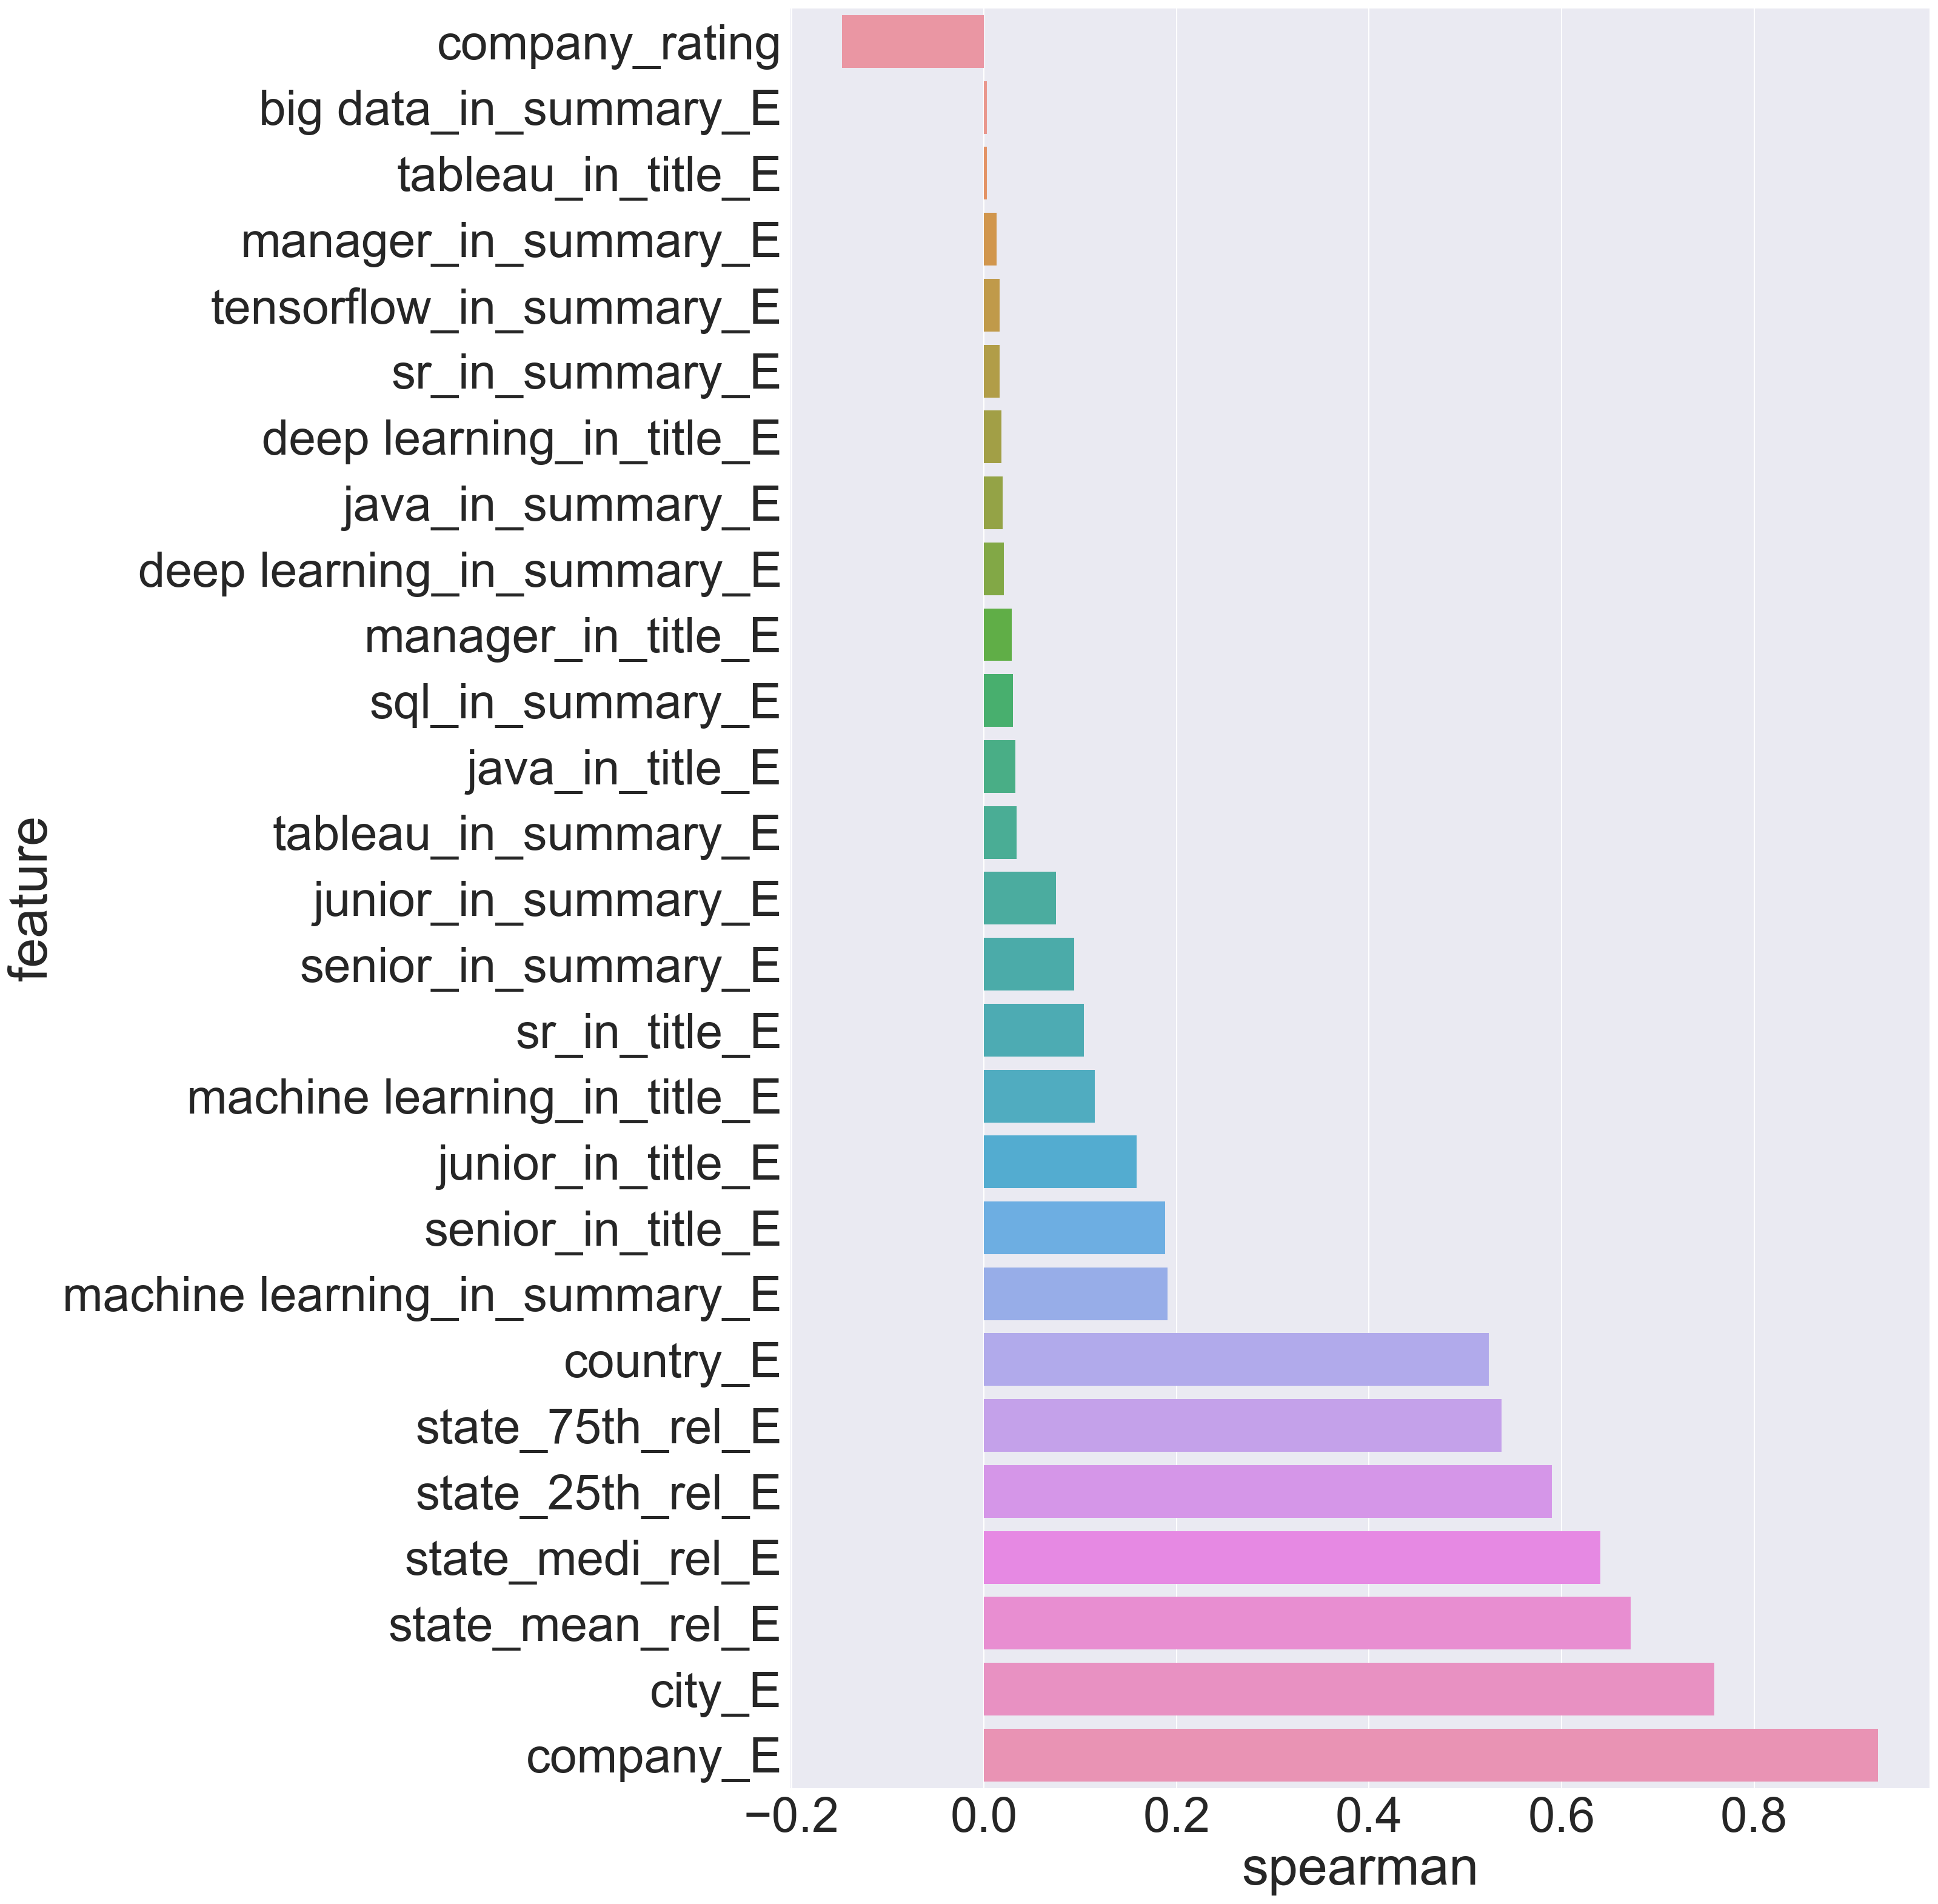

In [238]:
qualitative_vars = [
    'city','company','country','state_25th_rel',
    'state_medi_rel','state_mean_rel','state_75th_rel'
                   ]
qualitative_vars.extend([title_kw+'_in_title' for title_kw in title_kws])
qualitative_vars.extend([summary_kw+'_in_summary' for summary_kw in summary_kws])

quantitative_vars = ['company_rating',
                    ]

def encode(frame, feature):
    sns.set(font_scale = 1.2)
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'salary_num']].groupby(feature).mean()['salary_num']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

qual_encoded = []
for q in qualitative_vars:  
    encode(salaries_by_state_ave, q)
    qual_encoded.append(q+'_E')

features = quantitative_vars + qual_encoded

spr = pd.DataFrame()
spr['feature'] = features
spr['spearman'] = [salaries_by_state_ave[f].corr(salaries_by_state_ave['salary_num'], 'spearman') for f in features]
spr = spr.sort_values('spearman')
plt.figure(figsize=(15, 1*len(features)))
sns.set(font_scale = 4)
sns.barplot(data=spr, y='feature', x='spearman', orient='h');

It's somewhat surprising to see company rating doesn't seem to help justify a greater salary; this might indicate company ratings on Indeed are meaningless and can be fudged (more research would be needed to back this up, but it's possible to scrape some granular ratings such as 'job security rating', 'mgmt rating' etc... as shown in <a href=https://nycdatascience.com/blog/student-works/project-3-web-scraping-company-data-from-indeed-com-and-dice-com/>this</a> project by a fellow GA student.

From the heatmap and this bar plot of Pearson correlations, it seems the wording of Job Title and Job Summary have very little bearing on the salary, far less than the company and/or country advertising the job.

Unfortunately time did not allow for a full analysis of the full vocabulary.

## Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

<center><h1>Web Scraping for Indeed.com and Predicting Salaries<br><br>
<center>EXECUTIVE SUMMARY</h1></center>

<p><font color=grey>NB please use materials in folder `/test_with_ppc_10000_multi_domain_no_quotes`... this is the intended version, although several "test" folders and other iterations(e.g. searching with `"Data Scientist"` rather than `Data Scientist`) have been included, for further reading.</p>
<p>Estimated word count = 1,000</p>
</font>

<h3>Introduction</h3>
In this project, data were collected by scraping multiple domains of the Indeed online job market, and compared using several machine learning algorithms (including Regression, Clustering, and Decision Trees).

Postings on the site, advertising Data Science jobs in a range of cities across multiple countries, were scraped with the aim of comparing locations, companies, job titles & descriptions, and other details, as predictors of annual salary. Initial tests (restricted to USA data) indicated the vast majority of job postings did not include an indication of salary, and that the yield of useful data (unique records containing a reference to an annual or monthly salary) diminished rapidly with increasing number of pages scraped (see chart):

<img src='test/diminishing_returns.png'>

It was decided that, in order to reach a useful sample size for modelling, the scrape should:
- <b>Ignore “sponsored”</b> posts (the top 2-3 posts and bottom 2-3 posts on each page are sponsored job ads, very often repeated on consecutive pages; these would simply serve to add processing time for the sake of not much extra info)
- Be <b>recursive</b> (the scrape should break one it stops returning unique results)
- Be <b>multi-domain</b> (the scrape should look beyond USA, to any of <a href=https://www.indeed.com/worldwide>those listed</a> which yield 100 + results (see chart):

<img src='test/top_domains.png'>

- Break the USA search into <b>individual scrapes for its top states</b> yielding 100 + results: CA, MA, WA, DC, VA, NY, IL, TX.

In order to navigate language differences between domains, and to manage processing time, the search term “data scientist” was initially placed within quotes to return highly specific results, distinct from unrelated industries (e.g. "life scientist" and "data steward" had both came up during initial tests). This was later reversed, once the scrape had been optimised to occur within <b>12-15 minutes</b>, and it became clear there would be no downside to widening the search terms. 

<h3>Scraping</h3>
There are many methods available for scraping; BeautifulSoup was chosen to fetch the HTML source code of each page and store it for analysis offline. After significant time spent testing scrapes on individual countries and introducing different combinations of text-cleaning into the scrape, processing time was optimised <b>from 1.57 seconds per record</b> (reported by Python’s ‘tqdm’ library) <b>to 2.95 records per second</b>. The final scrape of 16 countries took just under 15 minutes to complete, and yielded 637 results with numeric salaries. Removing quotes from the search term yielded 813 total (with not much more time required). Salaries were converted into USD rates <b>during the recursive scrape</b> and descriptive statistics were calculated to inform a set of machine learning algorithms.

<h3>Modelling & conclusions</h3>
<img src='plots_tableau/Circles.png'>
          
Many geographical trends were examined and countries ranked in order of:
- number of jobs advertised
- aggregate salary advertised (from 25th & 75th percentiles to median & mean)
- density of jobs within the major cities vs more regional locations.

Certain countries (including significant data sources as Germany and China) were found not to include any figure for salary, whether annual or other; this may be due to local laws or society norms. The country with highest yield of numeric salaryd data was the UK, with its capital the greatest concentration of Data Science jobs at 135 (London yielded 101 more jobs than runner-up Paris). The capital was found to have a fairly good balance with regional centres such as Glasgow (3 jobs), Liverpool (4 jobs), and Cambridge (7 jobs).

The USA data had the widest range of salaries (see box plot elsewhere in this Notebook), with the highest value in the dataset (3x jobs advertised at USD159k in Mountain View, California) as well as one of the very lowest (USD15k in Buffalo), with only India having any jobs worse paid (except for a possible outlier in data from the Netherlands). The geographic areas with least deviation in salaries (apart from Spain, for which only 2 salaries were obtained) were India and Singapore, whose 15 and 10 jobs, respectively, lay within 2 standard deviations of the mean (except in the case of India where 2 jobs lay almost 4x SD's away). On the whole, geographical regions were found to be fairly varied in their salaries:

<style>
table, td, th {
    border: 3px solid red;
}

.table1 {
    border-collapse: collapse;
    border-color: blue;
}
</style>
<table class=table1>
    <tr><th>average displacement from the mean</th>
    <th>multiples of the standard deviation</th></tr>
    <tr><td>minimum</td><td>-1.898</td></tr>
    <tr><td>25th percentile</td><td>-0.692</td></tr>
    <tr><td>75th percentile</td><td>0.535</td></tr>
    <tr><td>maximum</td><td>2.835</td></tr>
</table>

<h3>Ideas for further analysis and returning to the data source:</h3>
- Sponsored posts… as mentioned, these were not scraped and so there remains an opportunity to correlate them to company ratings and salary amounts.
- Scrape with alternative search terms such as "Data Analyst", "Machine Learning Engineer" to more fully explore these titles and the vocabulary associated with them.
- Set up a weekly scrape that stores and charts trends across a year.
- Expand the scraper to all Indeed domains, and dig deeper into the reasons why certain countries never list any salary data.
- The balance of urban vs regional centres, in terms of salary aggregates as discussed above for London vs smaller UK cities, could provide a very interesting project once the scrape was expanded to all Indeed domains; this was not investigated here because of the significant time that'd have been required to classify cities in each country as urban vs regional (perhaps a search of Wikipedia's API, for population data, would supply the necessary data).

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

###### Link below...

<font size=16><a href=http://oisteadman.pythonanywhere.com/>Django site</a> 🏗 ... a work-in-progress!